In [4]:
!pip install --upgrade pip
!pip install numpy pandas scipy torch torchvision

!pip install insightface
!pip install onnxruntime

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [7]:
import datetime
import numpy as np
import os
import os.path as osp
import glob
import cv2
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image
import matplotlib.pyplot as plt

app = FaceAnalysis(name="buffalo_l")
app.prepare(ctx_id=0, det_size=(640, 640))

swapper = insightface.model_zoo.get_model(
    "weights/inswapper_128.onnx", download=False, download_zip=False
)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/ubuntu/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/ubuntu/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/ubuntu/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/ubuntu/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/ubuntu/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
se

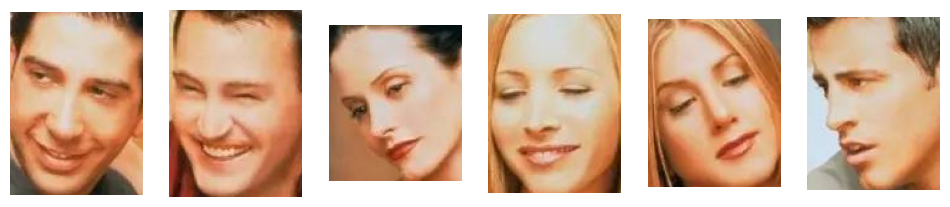

In [13]:
img = ins_get_image("t1")
faces = app.get(img)

fig, axs = plt.subplots(1, 6, figsize=(12, 5))

for i, face in enumerate(faces):
    bbox = face["bbox"]
    bbox = [int(b) for b in bbox]
    axs[i].imshow(img[bbox[1] : bbox[3], bbox[0] : bbox[2], ::-1])
    axs[i].axis("off")

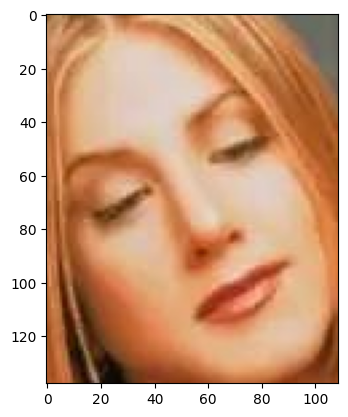

In [9]:
faces = sorted(faces, key=lambda x: x.bbox[0])
res = img.copy()
source_face = faces[0]

bbox = source_face["bbox"]
bbox = [int(b) for b in bbox]
plt.imshow(img[bbox[1] : bbox[3], bbox[0] : bbox[2], ::-1])
plt.show()

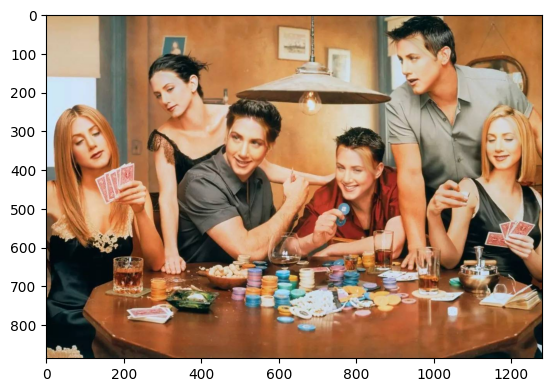

In [10]:
for face in faces:
    res = swapper.get(res, face, source_face, paste_back=True)

plt.imshow(res[:, :, ::-1])
plt.show()

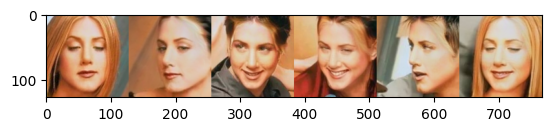

In [11]:
res = []
for face in faces:
    _img, _ = swapper.get(img, face, source_face, paste_back=False)
    res.append(_img)
res = np.concatenate(res, axis=1)

plt.imshow(res[:, :, ::-1])
plt.show()

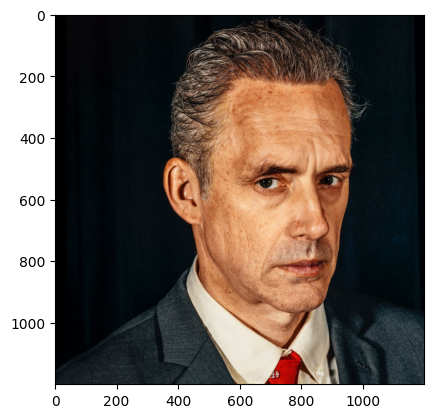

In [14]:
import matplotlib.pyplot as plt

rob = cv2.imread("img/UsJordan.jpg")
plt.imshow(rob[:, :, ::-1])
plt.show()

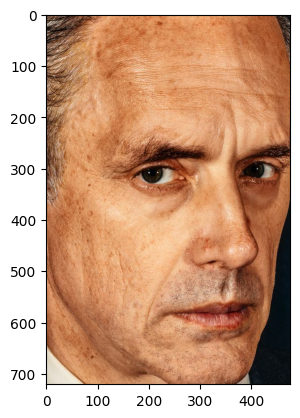

In [15]:
rob_faces = app.get(rob)
assert len(rob_faces) == 1
rob_face = rob_faces[0]
bbox = rob_face["bbox"]
bbox = [int(b) for b in bbox]
plt.imshow(rob[bbox[1] : bbox[3], bbox[0] : bbox[2], ::-1])
plt.show()

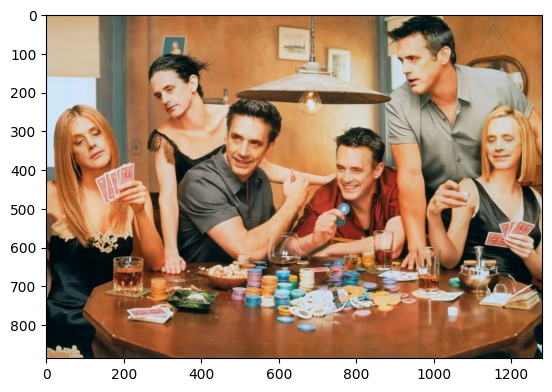

In [17]:
faces = app.get(img)
res = img.copy()
for face in faces:
    res = swapper.get(res, face, rob_face, paste_back=True)
plt.imshow(res[:, :, ::-1])
plt.show()

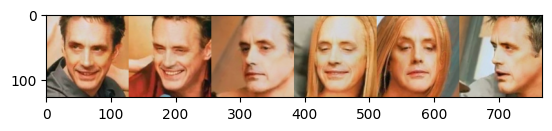

In [18]:
res = []
for face in faces:
    _img, _ = swapper.get(img, face, rob_face, paste_back=False)
    res.append(_img)
res = np.concatenate(res, axis=1)

plt.imshow(res[:, :, ::-1])
plt.show()

## Swap with Monty Python

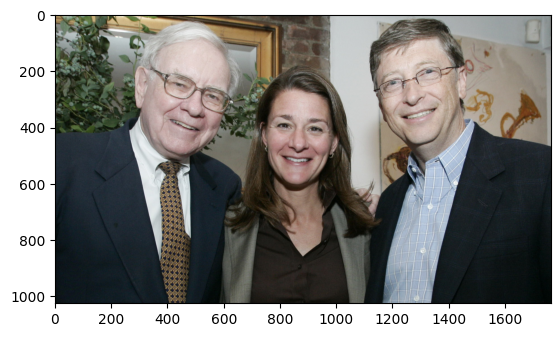

In [19]:
monty = cv2.imread("img/UsBuffettMelinaBill.jpg")
plt.imshow(monty[:, :, ::-1])
plt.show()

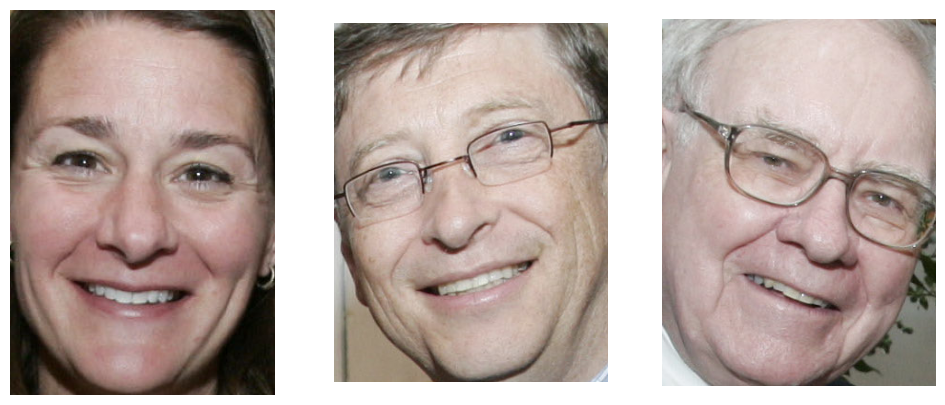

In [31]:
faces = app.get(monty)
fig, axs = plt.subplots(1, len(faces), figsize=(12, 5))

for i, face in enumerate(faces):
    bbox = face["bbox"]
    bbox = [int(b) for b in bbox]
    axs[i].imshow(monty[bbox[1] : bbox[3], bbox[0] : bbox[2], ::-1])
    axs[i].axis("off")

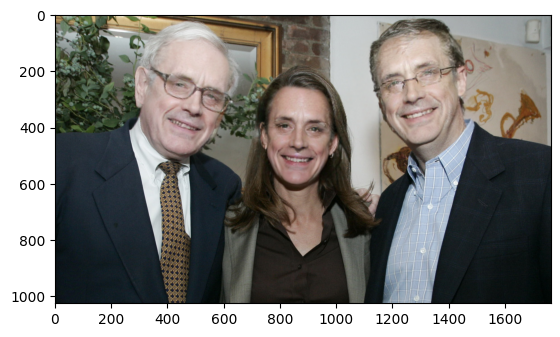

In [32]:
faces = app.get(monty)
res = monty.copy()
for face in faces:
    res = swapper.get(res, face, rob_face, paste_back=True)

plt.imshow(res[:, :, ::-1])
plt.show()

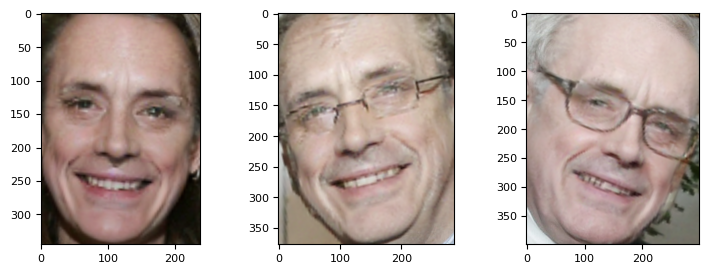

In [36]:
subplot_size = 3
fig, axs = plt.subplots(
    1, len(faces), figsize=(subplot_size * len(faces), subplot_size)
)

if len(faces) == 1:
    axs = [axs]

for i, face in enumerate(faces):
    bbox = face["bbox"]
    bbox = [int(b) for b in bbox]
    axs[i].imshow(res[bbox[1] : bbox[3], bbox[0] : bbox[2], ::-1])
    axs[i].axis("on")
    axs[i].tick_params(axis="both", which="major", labelsize=8)

# plt.tight_layout()
plt.show()

# Swap two faces

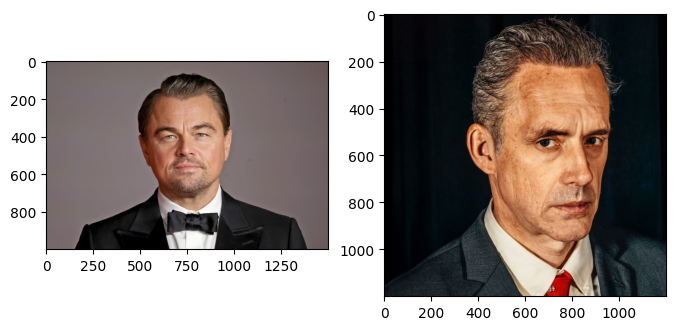

In [37]:
img1 = cv2.imread("img/UsDicaprio.jpg")
img2 = cv2.imread("img/UsJordan.jpg")

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(img1[:, :, ::-1])
axs[1].imshow(img2[:, :, ::-1])

plt.show()

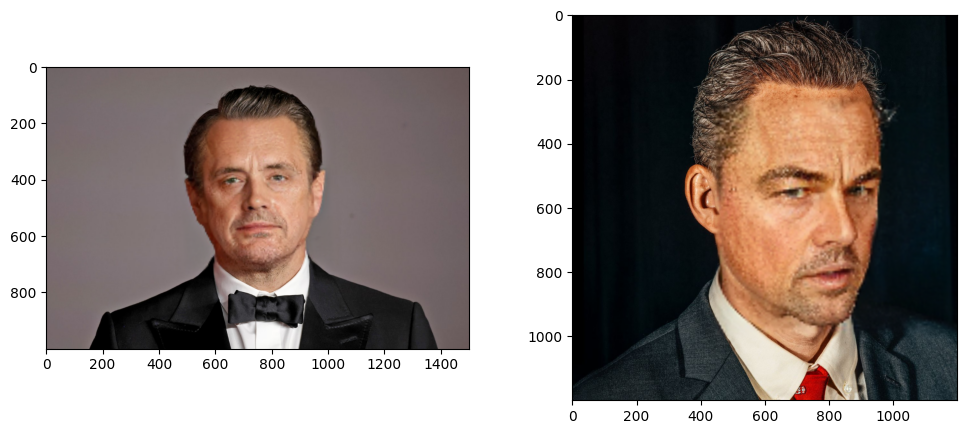

In [38]:
face1 = app.get(img1)[0]
face2 = app.get(img2)[0]

img1_ = img1.copy()
img2_ = img2.copy()
img1_ = swapper.get(img1_, face1, face2, paste_back=True)
img2_ = swapper.get(img2_, face2, face1, paste_back=True)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].imshow(img1_[:, :, ::-1])
axs[1].imshow(img2_[:, :, ::-1])

plt.show()

In [39]:
def swap_n_show(img1_fn, img2_fn, app, swapper, plot_before=True, plot_after=True):
    img1 = cv2.imread(img1_fn)
    img2 = cv2.imread(img2_fn)

    if plot_before:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(img1[:, :, ::-1])
        axs[0].axis("off")
        axs[1].imshow(img2[:, :, ::-1])
        axs[1].axis("off")
        plt.show()

    # Do the swap
    face1 = app.get(img1)[0]
    face2 = app.get(img2)[0]

    img1_ = img1.copy()
    img2_ = img2.copy()
    if plot_after:
        img1_ = swapper.get(img1_, face1, face2, paste_back=True)
        img2_ = swapper.get(img2_, face2, face1, paste_back=True)
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(img1_[:, :, ::-1])
        axs[0].axis("off")
        axs[1].imshow(img2_[:, :, ::-1])
        axs[1].axis("off")
        plt.show()
    return img1_, img2_

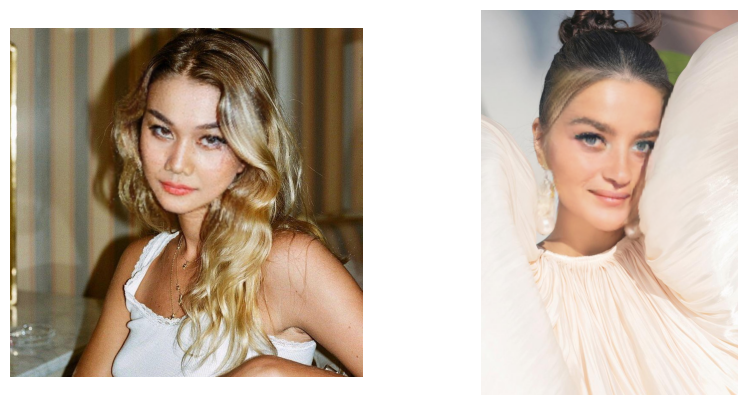

In [40]:
_ = swap_n_show(
    "img/FrAdeleFarine.jpg",
    "img/VnThanhHang.jpg",
    app,
    swapper,
)